<a href="https://www.kaggle.com/code/oscarm524/ps-s3-ep17-eda-modeling-submission?scriptVersionId=133492516" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Notebook Versions](#1)

[2. Loading Libraries](#2)

[3. Reading Data Files](#3)

[4. Data Exploration](#4)

[5. Baseline Modeling 1.0](#5)

<a id="1"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Notebook Versions</h1>

1. Version 1 (06/13/2023)
    * EDA 
    * Baseline modeling 1.0
    

2. Version 2 (06/13/2023)
    * Updating baseline modeling 1.0
    
<a id="2"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Loading Libraries</h1>    

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm.notebook import tqdm

import re

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
# from pygam import LogisticGAM, s, f, l, te

<a id="3"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1> 

In [2]:
train = pd.read_csv('../input/playground-series-s3e17/train.csv')
test = pd.read_csv('../input/playground-series-s3e17/test.csv')
original = pd.read_csv('../input/machine-failure-predictions/machine failure.csv')
submission = pd.read_csv('../input/playground-series-s3e17/sample_submission.csv')

print('The dimension of the train synthetic dataset is:', train.shape)
print('The dimension of the test synthetic dataset is:', test.shape)
print('The dimension of the orginal dataset is:', original.shape)
print('The dimension of the submission dataset is:', submission.shape)

The dimension of the train synthetic dataset is: (136429, 14)
The dimension of the test synthetic dataset is: (90954, 13)
The dimension of the orginal dataset is: (10000, 14)
The dimension of the submission dataset is: (90954, 2)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       136429 non-null  int64  
 1   Product ID               136429 non-null  object 
 2   Type                     136429 non-null  object 
 3   Air temperature [K]      136429 non-null  float64
 4   Process temperature [K]  136429 non-null  float64
 5   Rotational speed [rpm]   136429 non-null  int64  
 6   Torque [Nm]              136429 non-null  float64
 7   Tool wear [min]          136429 non-null  int64  
 8   Machine failure          136429 non-null  int64  
 9   TWF                      136429 non-null  int64  
 10  HDF                      136429 non-null  int64  
 11  PWF                      136429 non-null  int64  
 12  OSF                      136429 non-null  int64  
 13  RNF                      136429 non-null  int64  
dtypes: f

In [4]:
train.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [5]:
train.describe()

,id,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000
mean,68214.000000,299.862776,309.941070,1520.331110,40.348643,104.408901,0.015744,0.001554,0.005160,0.002397,0.003958,0.002258
std,39383.804275,1.862247,1.385173,138.736632,8.502229,63.965040,0.124486,0.039389,0.071649,0.048899,0.062789,0.047461
min,0.000000,295.300000,305.800000,1181.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34107.000000,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68214.000000,300.000000,310.000000,1493.000000,40.400000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,102321.000000,301.200000,310.900000,1580.000000,46.100000,159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,136428.000000,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
original.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [7]:
original.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


> <div class="alert alert-block alert-info">
<b>💡</b> There are no missing values neither in the competition nor the original dataset. Also, by a quick eye-ball comparison of the summary statistics of the train and test datasets, they seem to have similar distributions. 
</div>

<a id="4"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1>

First, we start by visualizing the variable of interest.

In [8]:
round(100*train['Machine failure'].value_counts() / train.shape[0], 2) 

0    98.43
1     1.57
Name: Machine failure, dtype: float64

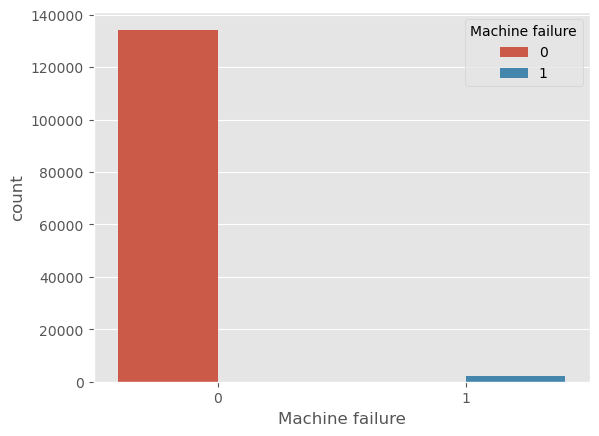

In [9]:
sns.countplot(x = 'Machine failure', hue = 'Machine failure', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above chart, we see that the data is extreme imbalanced (~99%-~1%).</div>

We next proceed to explore the relationship between the input and target variables.

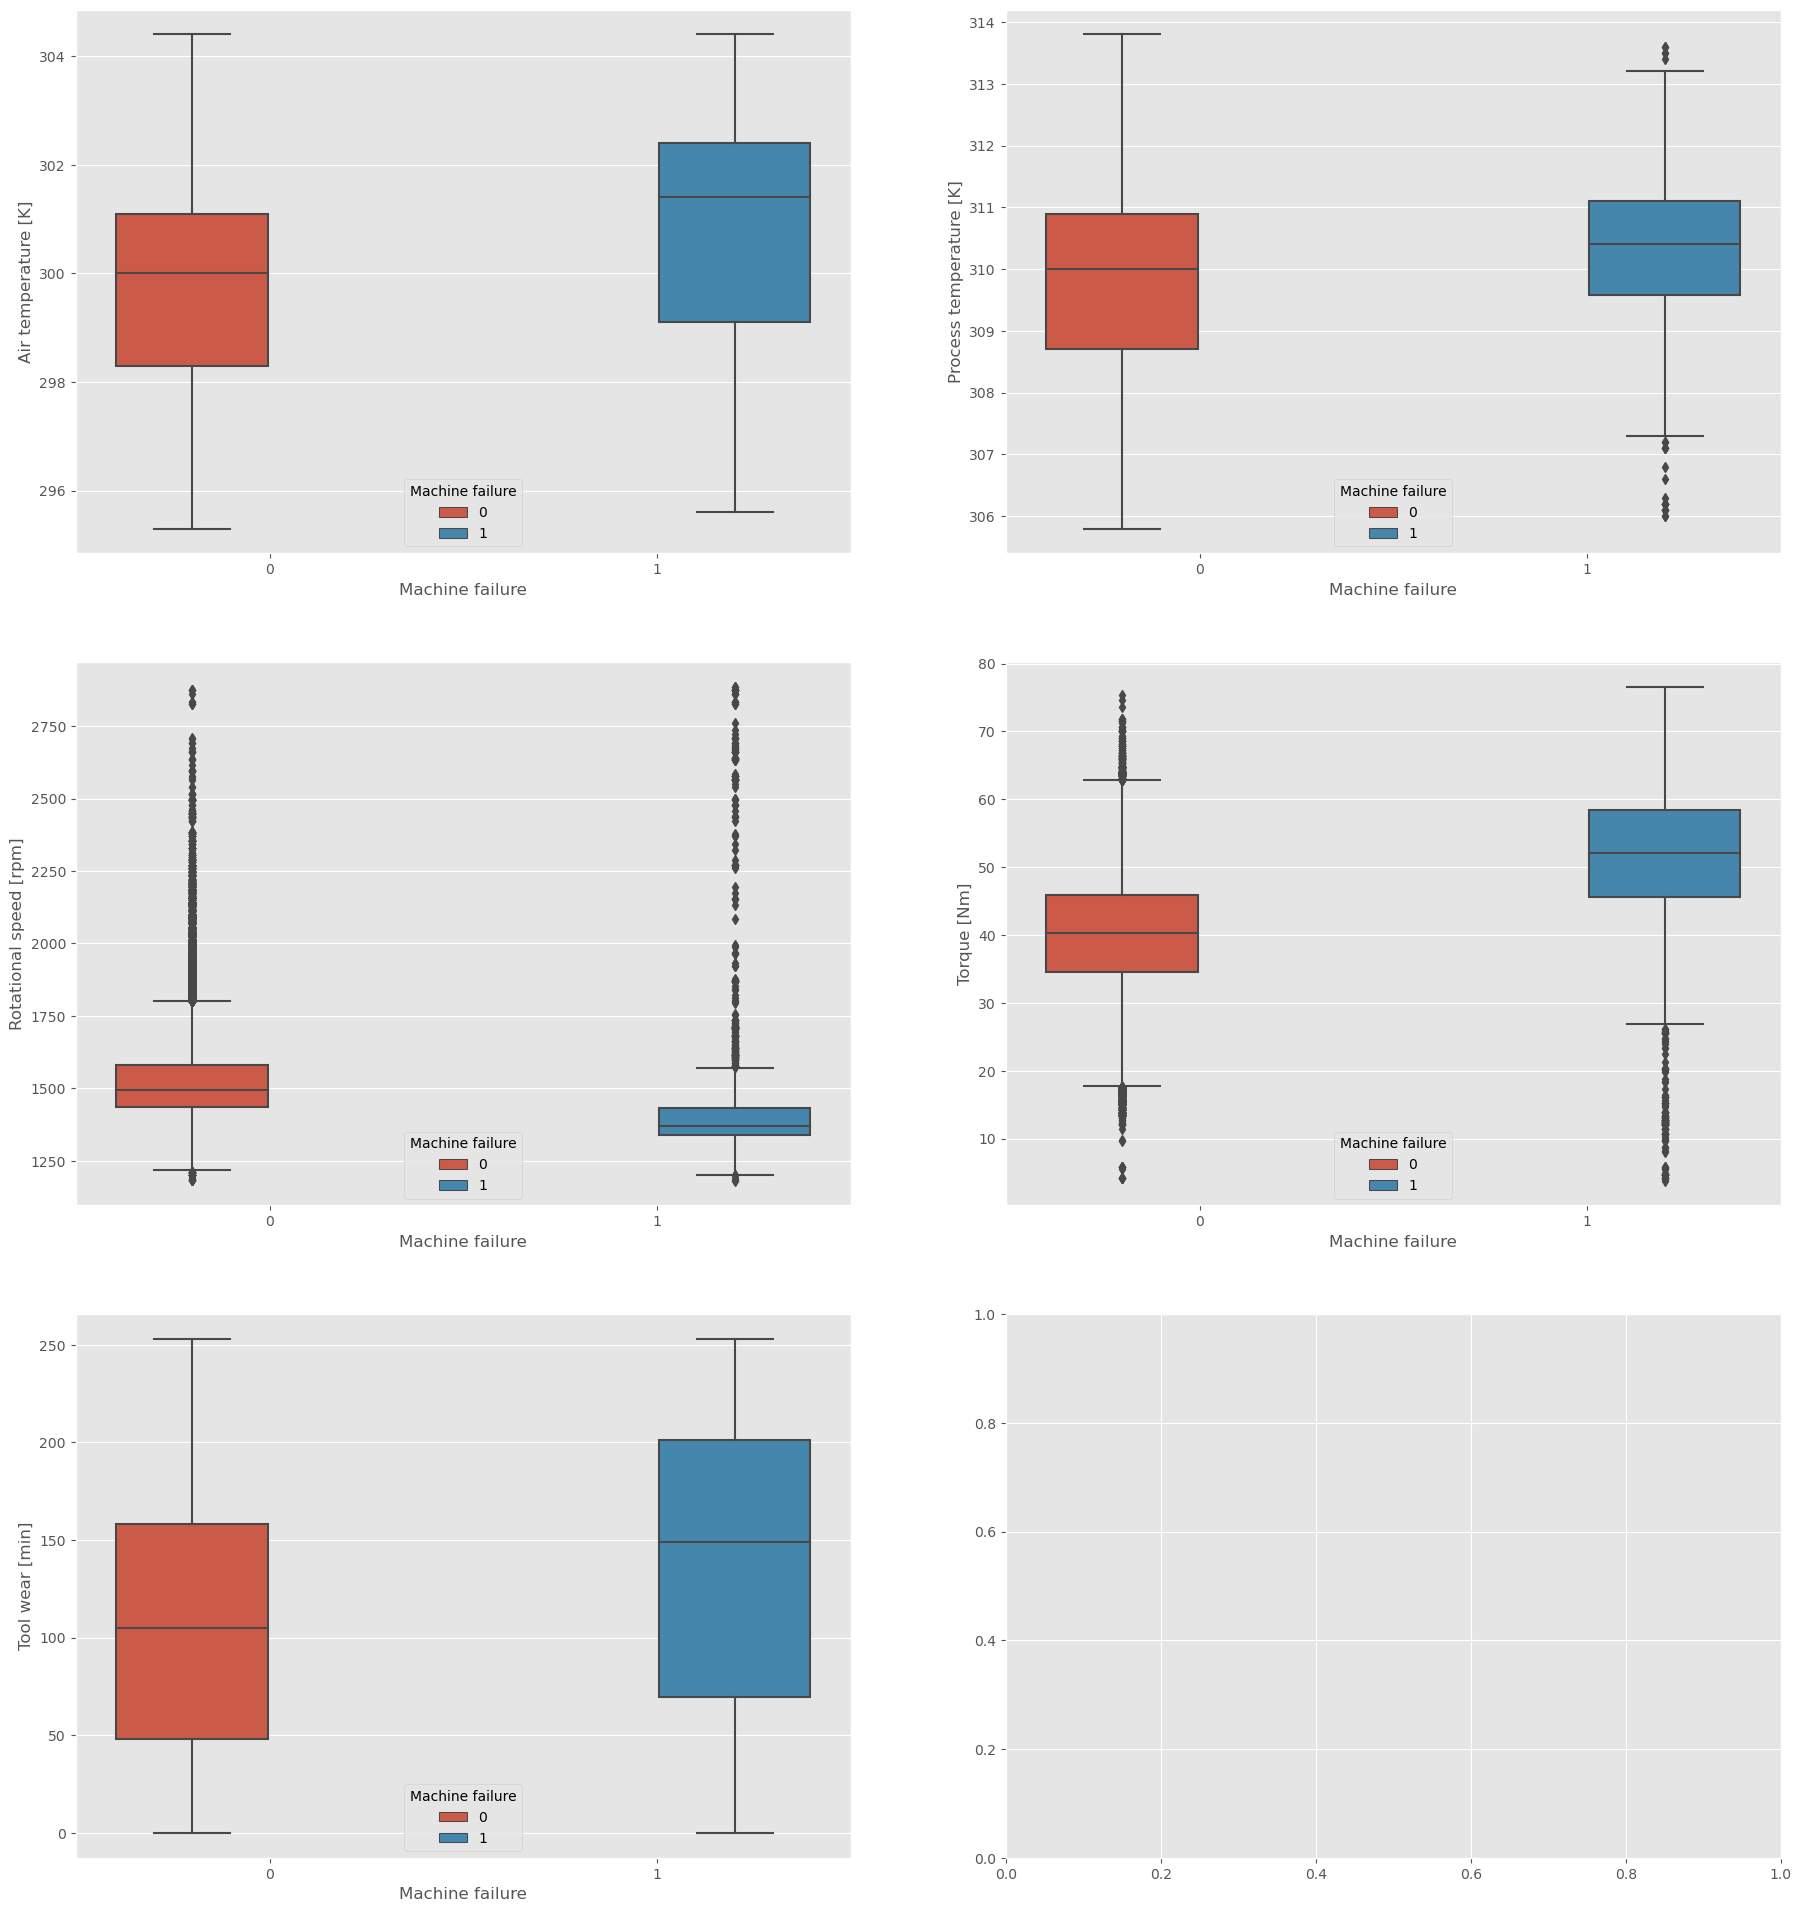

In [10]:
fig, axes = plt.subplots(3, 2, figsize = (22, 24))

sns.boxplot(ax = axes[0, 0], x = 'Machine failure', y = 'Air temperature [K]', hue = 'Machine failure', data = train)
sns.boxplot(ax = axes[0, 1], x = 'Machine failure', y = 'Process temperature [K]', hue = 'Machine failure', data = train)
sns.boxplot(ax = axes[1, 0], x = 'Machine failure', y = 'Rotational speed [rpm]', hue = 'Machine failure', data = train)
sns.boxplot(ax = axes[1, 1], x = 'Machine failure', y = 'Torque [Nm]', hue = 'Machine failure', data = train);
sns.boxplot(ax = axes[2, 0], x = 'Machine failure', y = 'Tool wear [min]', hue = 'Machine failure', data = train);

<b>From the above boxplots, we see the following:</b><br> 
<ul>
    <li> The median Air temperature [K] is higher when machine failure is 1. </li>
    <li> The median of Torque [Nm] is higher when machine failure is 1. </li>
    <li> The median of Rotational speed [rpm] is higher when machine failure is 0. </li>
    <li> The median of Tool wear [min] is higher when machine failure is 1. </li>
</ul>

Next, we compare the number of machine failures within `Type`.

In [11]:
pd.crosstab(train['Type'], train['Machine failure'])

Machine failure,0,1
Type,,
H,8807,116
L,93759,1595
M,31715,437


Next, we compare the distribution of the continuous features between the `train` and `test` datasets.

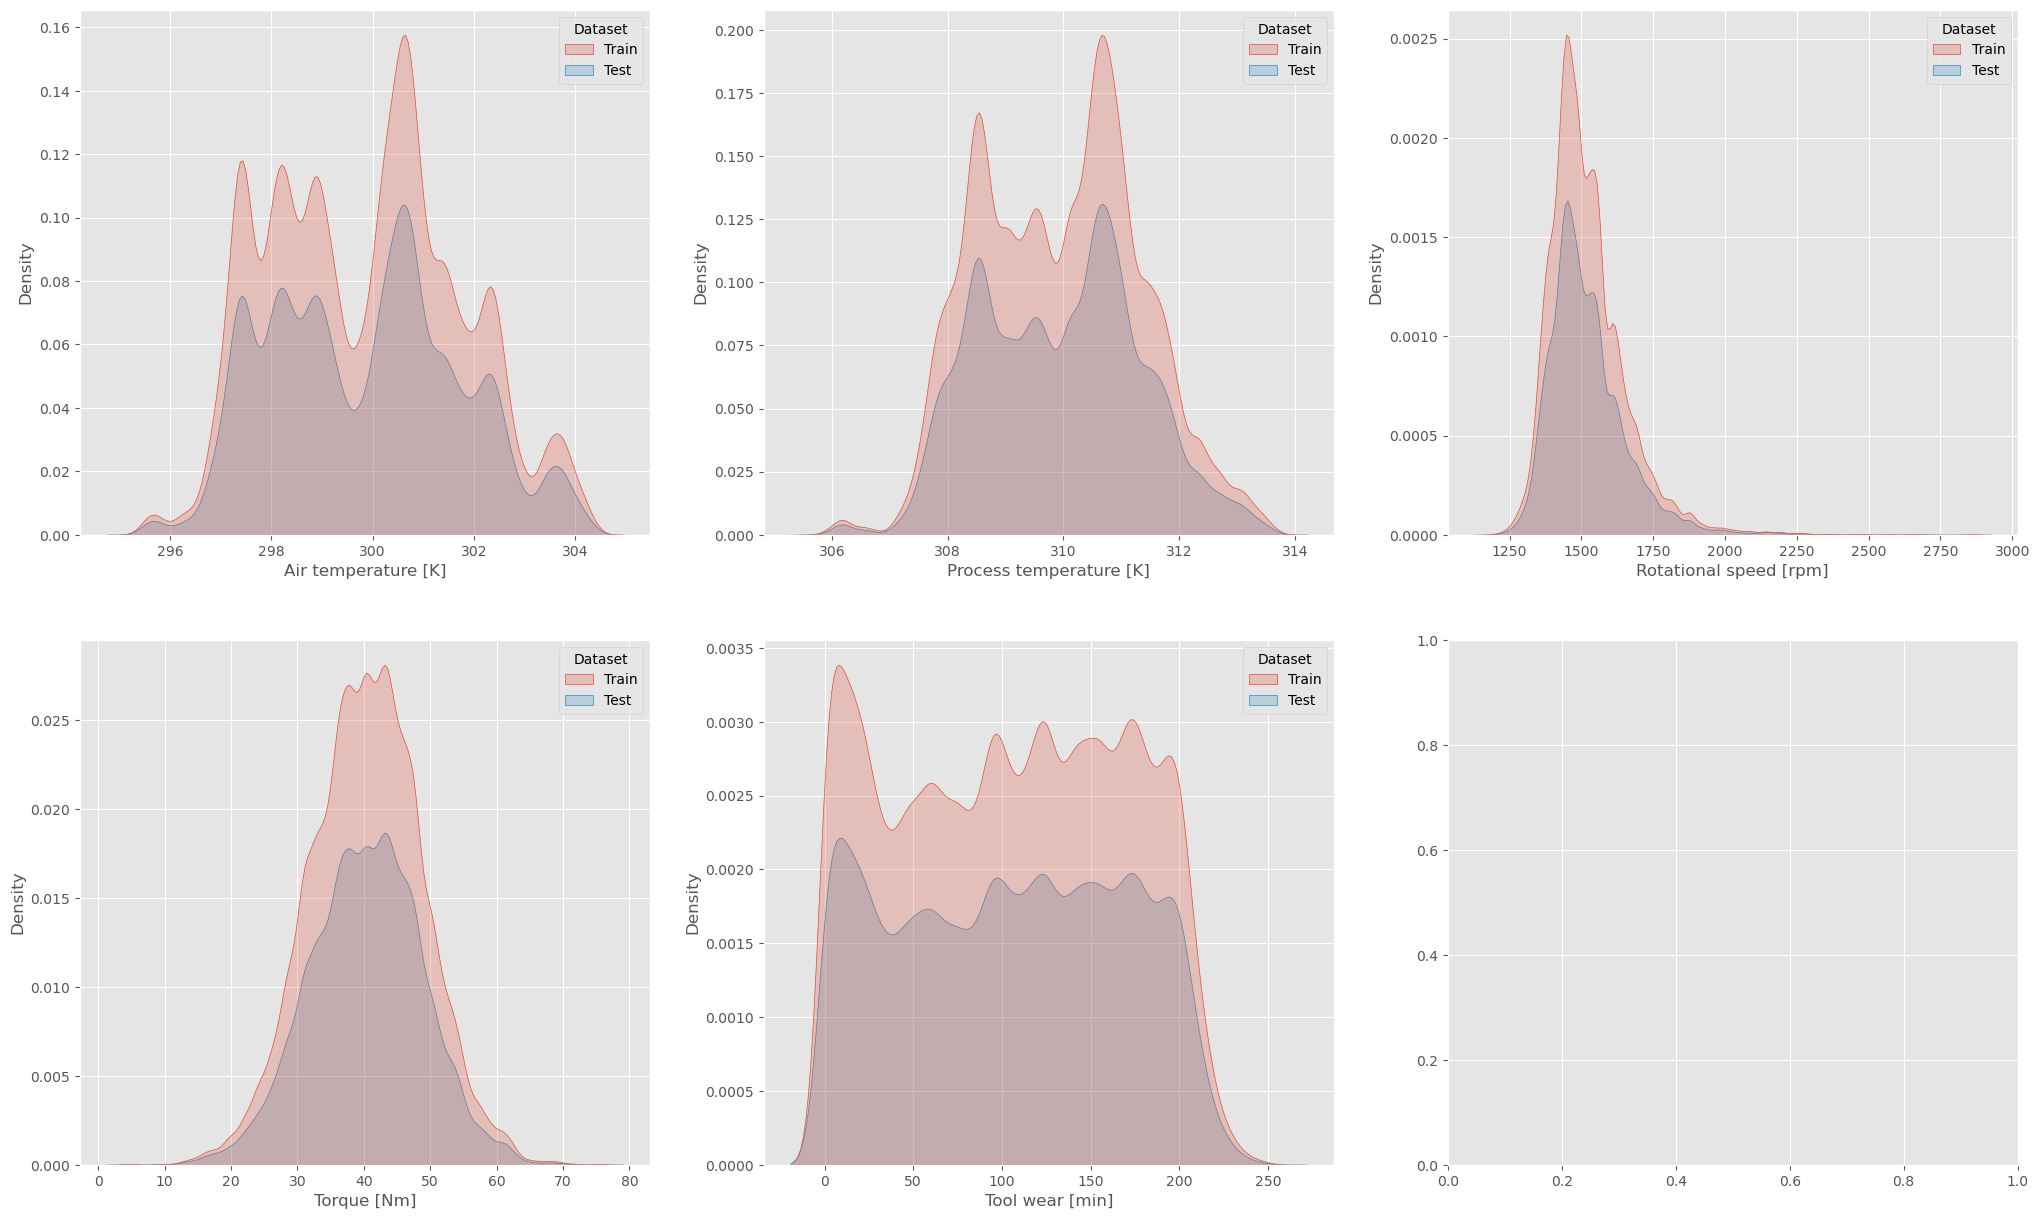

In [12]:
train_vis = train[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']].copy()
test_vis = test[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']].copy()

train_vis['Dataset'] = 'Train'
test_vis['Dataset'] = 'Test'
data_tot = pd.concat([train_vis, test_vis], axis = 0).reset_index(drop = True)

fig, axes = plt.subplots(2, 3, figsize = (25, 15))

sns.kdeplot(ax = axes[0, 0], x = 'Air temperature [K]', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 1], x = 'Process temperature [K]', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 2], x = 'Rotational speed [rpm]', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 0], x = 'Torque [Nm]', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 1], x = 'Tool wear [min]', hue = 'Dataset', data = data_tot, fill = True);

From the above plots, we see that the distributions of the continuous features are very similar in the `train` and `test` datasets. Next we check for duplicates.

In [13]:
print('There are', train.shape[0], 'observations in the train dataset')
print('There are', train.drop(columns = ['id', 'Machine failure'], axis = 1).drop_duplicates().shape[0], 'unique observations in the train dataset')

There are 136429 observations in the train dataset
There are 135274 unique observations in the train dataset


In [14]:
print('There are', test.shape[0], 'observations in the test dataset')
print('There are', test.drop(columns = ['id'], axis = 1).drop_duplicates().shape[0], 'unique observations in the test dataset')

There are 90954 observations in the test dataset
There are 90431 unique observations in the test dataset


In [15]:
to_consider = train.drop(columns = ['id', 'Machine failure'], axis = 1).columns.tolist()

train_dup = train.drop(columns = ['id', 'Machine failure'], axis = 1).drop_duplicates()
test_dup = test.drop(columns = ['id'], axis = 1).drop_duplicates()
duplicates = pd.merge(train_dup, test_dup, on = to_consider)

print('There are', duplicates.shape[0], 'rows that appear in the train and test datasets.\n')

There are 1021 rows that appear in the train and test datasets.



<a id="5"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 1.0</h1>

In this section, we start building some standard models. First, we consolidate the `train` and `original` datasets as follows:

In [16]:
le = LabelEncoder()

train['generated'] = 1
original['generated'] = 0
test['generated'] = 1

train.drop(columns = ['id', 'Product ID'], axis = 1, inplace = True)
original.drop(columns = ['UDI', 'Product ID'], axis = 1, inplace = True)

train = pd.concat([train, original], axis = 0).reset_index(drop = True)
train['Type'] = le.fit_transform(train['Type'])

train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

Next we proceed to build a couple of baseline models as shown below. Also, we ensemble the baseline model predictions using a simple average.

In [17]:
X = train.drop(columns = ['Machinefailure'], axis = 1)
Y = train['Machinefailure']

test_baseline = test.drop(columns = ['id', 'ProductID'], axis = 1)
test_baseline['Type'] = le.transform(test_baseline['Type'])

gb_cv_scores, gb_preds = list(), list()
hist_cv_scores, hist_preds = list(), list()
lgb_cv_scores, lgb_preds = list(), list()
xgb_cv_scores, xgb_preds = list(), list()
ens_cv_scores, ens_preds = list(), list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
    
for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
    print('---------------------------------------------------------------')
    
    ######################
    ## GradientBoosting ##
    ######################
        
    gb_md = GradientBoostingClassifier(n_estimators = 500, 
                                       max_depth = 7, 
                                       learning_rate = 0.01,
                                       min_samples_split = 10, 
                                       min_samples_leaf = 20).fit(X_train, Y_train) 
    
    gb_pred_1 = gb_md.predict_proba(X_test[X_test['generated'] == 1])[:, 1]
    gb_pred_2 = gb_md.predict_proba(test_baseline)[:, 1]
            
    gb_score_fold = roc_auc_score(Y_test[X_test['generated'] == 1], gb_pred_1)
    gb_cv_scores.append(gb_score_fold)
    gb_preds.append(gb_pred_2)
    
    print('Fold', i, '==> GradientBoositng oof ROC-AUC score is ==>', gb_score_fold)
    
    ##########################
    ## HistGradientBoosting ##
    ##########################
        
    hist_md = HistGradientBoostingClassifier(l2_regularization = 0.01,
                                             early_stopping = False,
                                             learning_rate = 0.01,
                                             max_iter = 1000,
                                             max_depth = 15,
                                             max_bins = 255,
                                             min_samples_leaf = 30,
                                             max_leaf_nodes = 30).fit(X_train, Y_train)
    
    hist_pred_1 = hist_md.predict_proba(X_test[X_test['generated'] == 1])[:, 1]
    hist_pred_2 = hist_md.predict_proba(test_baseline)[:, 1]

    hist_score_fold = roc_auc_score(Y_test[X_test['generated'] == 1], hist_pred_1)
    hist_cv_scores.append(hist_score_fold)
    hist_preds.append(hist_pred_2)
    
    print('Fold', i, '==> HistGradient oof ROC-AUC score is ==>', hist_score_fold)
        
    ##############
    ## LightGBM ##
    ##############
        
    lgb_md = LGBMClassifier(n_estimators = 1000,
                            max_depth = 10,
                            learning_rate = 0.01,
                            num_leaves = 70,
                            reg_alpha = 3,
                            reg_lambda = 3,
                            subsample = 0.7,
                            colsample_bytree = 0.7,
                            device = 'gpu').fit(X_train, Y_train)
    
    lgb_pred_1 = lgb_md.predict_proba(X_test[X_test['generated'] == 1])[:, 1]
    lgb_pred_2 = lgb_md.predict_proba(test_baseline)[:, 1]

    lgb_score_fold = roc_auc_score(Y_test[X_test['generated'] == 1], lgb_pred_1)    
    lgb_cv_scores.append(lgb_score_fold)
    lgb_preds.append(lgb_pred_2)
    
    print('Fold', i, '==> LightGBM oof ROC-AUC score is ==>', lgb_score_fold)
        
    #############
    ## XGBoost ##
    #############
        
    xgb_md = XGBClassifier(tree_method = 'gpu_hist',
                           colsample_bytree = 0.7, 
                           gamma = 0.8, 
                           learning_rate = 0.01, 
                           max_depth = 8, 
                           min_child_weight = 20, 
                           n_estimators = 1000, 
                           subsample = 0.7).fit(X_train, Y_train)
    
    xgb_pred_1 = xgb_md.predict_proba(X_test[X_test['generated'] == 1])[:, 1]
    xgb_pred_2 = xgb_md.predict_proba(test_baseline)[:, 1]

    xgb_score_fold = roc_auc_score(Y_test[X_test['generated'] == 1], xgb_pred_1)    
    xgb_cv_scores.append(xgb_score_fold)
    xgb_preds.append(xgb_pred_2)
    
    print('Fold', i, '==> XGBoost oof ROC-AUC score is ==>', xgb_score_fold)

    ##############
    ## Ensemble ##
    ##############
    
    ens_pred_1 = (gb_pred_1 + hist_pred_1 + lgb_pred_1 + xgb_pred_1) / 4
    ens_pred_2 = (gb_pred_2 + hist_pred_2 + lgb_pred_2 + xgb_pred_2) / 4
    
    ens_score_fold = roc_auc_score(Y_test[X_test['generated'] == 1], ens_pred_1)
    ens_cv_scores.append(ens_score_fold)
    ens_preds.append(ens_pred_2)
    
    print('Fold', i, '==> Ensemble oof ROC-AUC score is ==>', ens_score_fold)

---------------------------------------------------------------
Fold 0 ==> GradientBoositng oof ROC-AUC score is ==> 0.9567783720882754
Fold 0 ==> HistGradient oof ROC-AUC score is ==> 0.9621868811628524
Fold 0 ==> LightGBM oof ROC-AUC score is ==> 0.9649817283547353
Fold 0 ==> XGBoost oof ROC-AUC score is ==> 0.965868770798032
Fold 0 ==> Ensemble oof ROC-AUC score is ==> 0.9672012058605367
---------------------------------------------------------------
Fold 1 ==> GradientBoositng oof ROC-AUC score is ==> 0.951223692611634
Fold 1 ==> HistGradient oof ROC-AUC score is ==> 0.9582719461321507
Fold 1 ==> LightGBM oof ROC-AUC score is ==> 0.9567649583919413
Fold 1 ==> XGBoost oof ROC-AUC score is ==> 0.9539916608531482
Fold 1 ==> Ensemble oof ROC-AUC score is ==> 0.9577190745176728
---------------------------------------------------------------
Fold 2 ==> GradientBoositng oof ROC-AUC score is ==> 0.9579266396733467
Fold 2 ==> HistGradient oof ROC-AUC score is ==> 0.9589036953513403
Fold 2 =

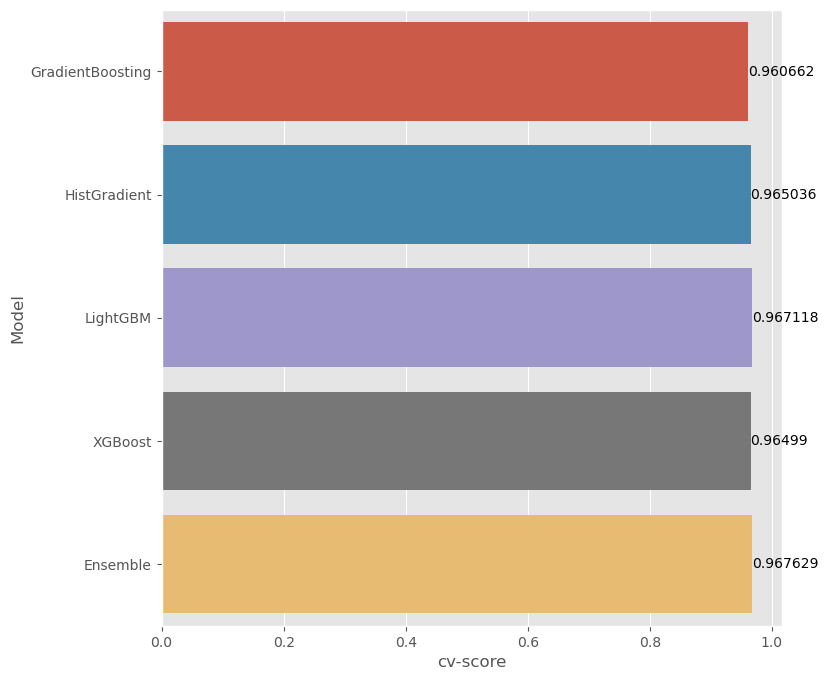

In [18]:
gb_cv_score = np.mean(gb_cv_scores)
hist_cv_score = np.mean(hist_cv_scores)
lgb_cv_score = np.mean(lgb_cv_scores)
xgb_cv_score = np.mean(xgb_cv_scores)
ens_cv_score = np.mean(ens_cv_scores)

model_perf = pd.DataFrame({'Model': ['GradientBoosting', 'HistGradient' ,'LightGBM', 'XGBoost', 'Ensemble'],
                           'cv-score': [gb_cv_score, hist_cv_score, lgb_cv_score, xgb_cv_score, ens_cv_score]})

plt.figure(figsize = (8, 8))
ax = sns.barplot(y = 'Model', x = 'cv-score', data = model_perf)
ax.bar_label(ax.containers[0]);

In [19]:
gb_preds_test = pd.DataFrame(gb_preds).apply(np.mean, axis = 0)
hist_preds_test = pd.DataFrame(hist_preds).apply(np.mean, axis = 0)
lgb_preds_test = pd.DataFrame(lgb_preds).apply(np.mean, axis = 0)
xgb_preds_test = pd.DataFrame(xgb_preds).apply(np.mean, axis = 0)
ens_preds_test = pd.DataFrame(ens_preds).apply(np.mean, axis = 0)

submission['Machine failure'] = hist_preds_test
submission.to_csv('GB_Baseline_submission.csv', index = False)

submission['Machine failure'] = hist_preds_test
submission.to_csv('Hist_Baseline_submission.csv', index = False)

submission['Machine failure'] = lgb_preds_test
submission.to_csv('LightGBM_Baseline_submission.csv', index = False)

submission['Machine failure'] = xgb_preds_test
submission.to_csv('XGBoost_Baseline_submission.csv', index = False)

submission['Machine failure'] = ens_preds_test
submission.to_csv('Ensemble_Baseline_submission.csv', index = False)